<a href="https://www.kaggle.com/code/mcpenguin/gaia-stellar-classification-lightgbm-91-acc?scriptVersionId=143235302" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

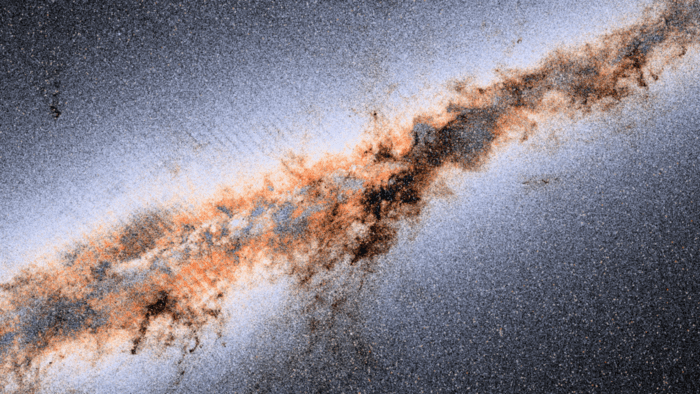

# Stellar Classification

In this notebook, we investigate the Gaia dataset for stellar classification. We will first perform some initial EDA on the data, and then train a LightGBM model to classify the stars.

## Some of my other work

### Notebooks

- [Butterfly Image Classification](https://www.kaggle.com/code/mcpenguin/butterfly-classification-efficientnet-87)
- [Palmer Penguin EDA](https://www.kaggle.com/code/mcpenguin/palmer-archipelago-antarctica-penguin-eda)
- [Smoking and Drinking EDA + Classification](https://www.kaggle.com/code/mcpenguin/smoking-drinking-prediction-tfdf-71)
- [World Happiness Data Cleaning + EDA](https://www.kaggle.com/code/mcpenguin/world-happiness-data-cleaning-eda)
- [Precious Metals Stocks: EDA + Forecasting](https://www.kaggle.com/code/mcpenguin/precious-metals-stocks-eda-and-prediction)
- [Red Wine Quality EDA + Prediction](https://www.kaggle.com/code/mcpenguin/red-wine-quality-prediction)

### Datasets

- [The Complete Rollercoasters Dataset](https://www.kaggle.com/datasets/mcpenguin/rollercoasters)
- [Malaysian COVID-19 Data](https://www.kaggle.com/datasets/mcpenguin/malaysia-covid19)
- [Super Mario 64 Speedruns](https://www.kaggle.com/datasets/mcpenguin/super-mario-64-speedruns)

# Import Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import lightgbm as lgb

# Set Global Configuration Options

It is nice to specify global configuration options at the start of the notebook, so tweaking certain parameters does not require much "scrolling" down the notebook.

In [ ]:
class CONFIG:
    
    # global seed
    seed = 42
    
    # number of samples to subsample (for debugging purposes)
    # if this is None, use the full dataset
    subsample = None
    
    # number of rounds to use for our LightGBM model
    model_num_rounds = 200

In [ ]:
pd.set_option('display.max_columns', None)

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    
seed_everything(CONFIG.seed)

# Load Data

In [ ]:
df = pd.read_csv("/kaggle/input/gaia-data-set-for-stellar-classificationdr3/dataGaia.csv")
df.head()

# Understanding the Data

## Initial Info about Data

We can first check some information about the dataset, including how many missing values there are, the shape of the data, as well as the dtypes of each of the columns.

In [ ]:
df.info()

From this, we see that

- Most parameters contain no missing values. The outlier to this are `pscol`, which contains only 16k non-null values.
- The parameters are already inferred to be floats/ints.

Our goal will be to classify the `SpType-ELS` variate.

## Column Descriptions

As always with new data, it is essential that we understand what the different columns means. Luckily, the dataset brief gives us some insight about what they mean:

- RA_ICRS: Right ascension in the ICRS (International Celestial Reference System) coordinate system.
- DE_ICRS: Declination in the ICRS coordinate system.
- Source: Unique identifier for an object in the Gaia catalogue.
- Plx: Trigonometric parallax of the celestial body in milliarcseconds.
- PM: Total proper motion of the celestial body in the sky in milliarcseconds per year.
- pmRA: Proper motion component in the right ascension direction in milliarcseconds per year.
- pmDE: Proper motion component in the declination direction in milliarcseconds per year.
- Gmag: Average apparent magnitude integrated in the G band.
- e_Gmag: Error in G magnitude.
- BPmag: Average apparent magnitude integrated in the BP blue band.
- e_BPmag: Error associated with BP magnitude.
- RPmag: Average apparent magnitude integrated in the RP red band.
- e_RPmag: Error in RP magnitude.
- GRVSmag: Average apparent magnitude integrated in the RVS band.
- e_GRVSmag: Error in RVS magnitude.
- BP-RP: BP-RP color index.
- BP-G: BP-G color index.
- G-RP: G-RP color index.
- pscol: pseudocolor estimated by gaia in um^-1
- Teff: Estimated effective temperature of the celestial object by Gaia in Kelvins.
- Dist: Distance to the celestial object: inverse of the parallax, in parsecs.
- Rad: Object radius estimate in terms of solar radius.
- Lum-Flame: Estimated object luminosity in terms of solar luminosity.
- Mass-Flame: Mass estimate in terms of solar mass.
- Age-Flame: Celestial object age in giga years.
- z-Flame: Redshift in km/s.
- SpType-ELS: Estimated spectral class by Gaia.

## Rough Distributions of the Data

We can also investigate the rough distributions of the data through the `describe` command.

In [ ]:
df.describe()

## Subsampling Data for Ease of Analysis

To speed up the computation of our analysis, we can only consider a subsample of our data for initial analysis.

In [ ]:
if CONFIG.subsample is not None:
    df = df.sample(CONFIG.subsample)

## Define Explanatory/Response Columns

For ease of analysis, we will explicitly define the explanatory columns used in our analysis, as well as our response column.

We will omit the `Unnamed: 0` index column from our analysis.

In [ ]:
explanatory_cols = ['RA_ICRS', 'DE_ICRS', 'Source', 'Plx', 'PM', 'pmRA',
       'pmDE', 'Gmag', 'e_Gmag', 'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag',
       'GRVSmag', 'e_GRVSmag', 'BP-RP', 'BP-G', 'G-RP', 'pscol', 'Teff',
       'Dist', 'Rad', 'Lum-Flame', 'Mass-Flame', 'Age-Flame', 'z-Flame']
response_col = 'SpType-ELS'

## Removing Trailing Whitespace for Stellar Classes

It appears that the stellar classes have a lot of trailing whitespaces, which might impact our readability. Let's remove these.

In [ ]:
df[response_col] = df[response_col].apply(lambda x: x.strip())

# Exploratory Data Analysis

We are now ready to begin exploratory data analysis of the data.

## Histograms of Explanatory Columns

Upon inspection, it seems that the variates in our data are all continuous. As such, to understand their distributions, it makes sense to plot the histograms for the data:

In [ ]:
nrows = (len(explanatory_cols)+1) // 2

fig, axes = plt.subplots(ncols=2, nrows=nrows, figsize=(20, nrows*5))
plt.subplots_adjust(hspace=0.5)

pbar = tqdm(list(zip(axes.flat, explanatory_cols)))
for ax, col in pbar:
    pbar.set_postfix(col=col)
    # we need to set bins explicitly, or plotting the graphs takes a long time
    # due to the amount of data
    sns.histplot(data=df, x=col, ax=ax, bins=50)
    ax.set_title(col)

plt.show()

## Countplot of Response Column

As our response column is categorical, it makes sense to plot a countplot to understand the distribution of the data with that.

In [ ]:
plt.figure(figsize=(15, 8))
ax = sns.countplot(data=df, x=response_col)
ax.set_title(response_col)
plt.show()

We see the data is relatively balanced, with the exception of the `O` class.

## Distributions of Explanatory Variates with Response

We can also investigate the distributions of the explanatory variates after taking into account the response by plotting box(en)plots of the x-variates, categorizing by the response.

In [ ]:
nrows = len(explanatory_cols)

fig, axes = plt.subplots(ncols=1, nrows=nrows, figsize=(15, nrows*8))
plt.subplots_adjust(hspace=0.5)

pbar = tqdm(list(zip(axes.flat, explanatory_cols)))
for ax, col in pbar:
    pbar.set_postfix(col=col)
    sns.boxenplot(data=df, y=col, x=response_col, ax=ax)
    ax.set_title(f"{col} vs. {response_col}")

plt.show()

From these, we see that

- even after accounting for `SpType-ELS`, many of the distributions of the explanatory variates are still skewed by a huge margin.
- there does not seem to be a single variate that is a great predictor at the response variate.

## Correlation Matrix between Explanatory Variates

We can investigate the correlations between the explanatory variates through a correlation matrix.

In [ ]:
plt.figure(figsize=(20, 20))
ax = sns.heatmap(df[explanatory_cols].corr(), annot=True)
plt.show()

We see the different variates have fairly small correlations. There seems to be a "square of correlations" in the middle, where we see that the various magnitude variates have fairly strong correlations with each other.

## Correlation Matrix Between Explanatory Variates and Response

We can investigate the correlation matrix between the explanatory variates and the response variate. In particular, we will convert `SpType-ELS` into a one-hot encoding so that we can investigate its correlations with the other variates.

For our classification, we will instead use a label encoding of the variate, but it is useful to use a one-hot encoding for this to see if any particular explanatory columns have a correlation with a particular stellar class.

In [ ]:
df_with_onehot = pd.get_dummies(df, columns=[response_col])
cat_cols = [col for col in df_with_onehot.columns if response_col in col]
not_cat_cols = [col for col in df_with_onehot.columns if response_col not in col]

corr = df_with_onehot.corr(numeric_only=True)
plt.figure(figsize=(10, 15))
ax = sns.heatmap(corr.loc[not_cat_cols, cat_cols], annot=True)
plt.show()

From this, we see that there are not that many strong correlations between the explanatory variates and the response variate.

# Label Encode Response

Prior to modelling, we will need to label-encode our response into a numeric value. To do this, we can use the `LabelEncoder` class.

In [ ]:
le = LabelEncoder()
df[response_col] = le.fit_transform(df[response_col])

In [ ]:
df.head()

# Train/Test Split

We will split our dataset into a training and test set.

In [ ]:
df_train, df_test = train_test_split(df, train_size=0.7)

## Load Into LGB Datasets

We will then load both dataframes into LightGBM datasets.

In [ ]:
train_data = lgb.Dataset(df_train[explanatory_cols], label=df_train[response_col])
test_data = lgb.Dataset(df_test[explanatory_cols], label=df_train[response_col])

# Modelling + Training

We will train a LightGBM model on our data. We choose LightGBM for this task as it offers relatively fast boosting models, and is able to natively support missing values in our data. Additionally, it also supports GPU acceleration, although this is not required for this notebook.

## Define Configuration Parameters

In [ ]:
params = {
    'num_leaves': 31, 
    'objective': 'multiclass',
    'num_class': len(df[response_col].unique())
}

num_rounds = CONFIG.model_num_rounds

## Training

In [ ]:
%%time

bst = lgb.train(params, train_data, num_rounds)

# Model Prediction

We can use our trained model to predict the stellar classes of the test set.

In [ ]:
pred = bst.predict(df_test[explanatory_cols]).argmax(axis=1)
pred_labels = le.inverse_transform(pred)
labels = le.inverse_transform(df_test[response_col])

In [ ]:
df_test[f"pred_{response_col}"] = pred_labels
df_test[response_col] = labels

# Model Evaluation

## Classification Report

One metric we can use to evaluate the accuracy of our model is to make a classification report for our model on the test set.

In [ ]:
print(classification_report(df_test[response_col], df_test[f"pred_{response_col}"]))

## Confusion Matrix

We can also plot the confusion matrix for our model to visualize the classification accuracy of our model.

In [ ]:
conf_matrix = confusion_matrix(df_test[response_col], df_test[f"pred_{response_col}"])

plt.figure(figsize=(8,8))
ax = sns.heatmap(conf_matrix, annot=True, 
                 xticklabels=le.classes_, yticklabels=le.classes_)
plt.show()

# Thank you for reading!